In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display
import scipy.stats as stats
import matplotlib.pyplot as plt
import pyreadstat
import seaborn as sns
from linearmodels.iv import IV2SLS
import rdrobust

In [2]:
#load df
file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/damonclark.dta"
df = pd.read_stata(file_path)
df

,passrate0,passrate2,vote
0,54.0,50.0,52.752293
1,60.0,60.0,27.215189
2,50.0,53.0,37.985214
3,40.0,53.0,65.759636
4,40.0,33.0,84.719101
...,...,...,...
657,36.0,27.0,75.572517
658,34.0,44.0,76.695435
659,47.0,57.0,81.458336
660,51.0,54.0,64.692131


In [3]:
#build preliminary variables
df['win'] = (df['vote'] >= 50).astype(int)  
df['lose'] = (df['vote'] < 50).astype(int) 

df['margin'] = df['vote'] - 50

df['margin_sq'] = df['margin'] ** 2

df['win_margin'] = df['win'] * df['margin']
df['win_margin_sq'] = df['win'] * df['margin_sq']

df['lose_margin'] = df['lose'] * df['margin']
df['lose_margin_sq'] = df['lose'] * df['margin_sq']

Q1 (a)
As base assumptions, we take that: (1) the schools are similar in all respects except for treatment (GM status in this case); (2) schools just above and just below the threshold are continuous and evenly distributed in all significant parameters (randomized); (3) no systematic manipulation is done on the part of the schools; and (4) all the assumptions that come with IV, meaning since the vote is used as an instrument for treatment outcome it must be relevant (predictive of actual treatment outcome) and exclusive (vote only affects treatment outcome and by direct means). This study uses fuzzy regression, meaning a vote of greater than 50% does not necessarily mean the school will receive treatment (though it does sharply increase the probability).

/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_21851/1962967336.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


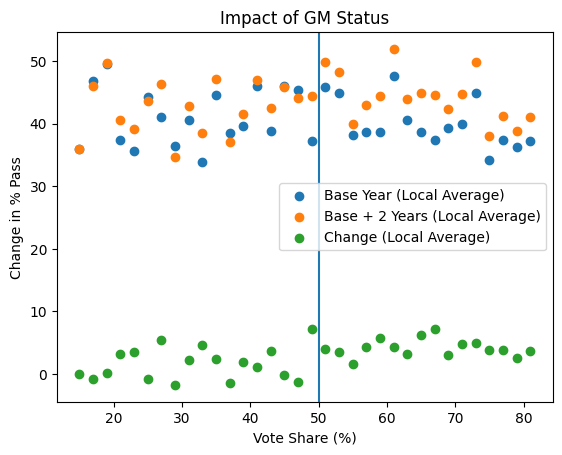

In [4]:
df['change_pass'] = df['passrate2'] - df['passrate0']

#2 % wide
bins = np.arange(15, 85, 2)  #interval is (15,85)
df['vote_bin'] = pd.cut(df['vote'], bins, labels=bins[:-1])  #vote to a bin

#local avgs
bin_means = df.groupby('vote_bin').agg(
    base_avg=('passrate0', 'mean'),
    base_2yrs_avg=('passrate2', 'mean'),
    change_avg=('change_pass', 'mean')
).reset_index()
bin_means['vote_bin'] = bin_means['vote_bin'].astype(float) 


plt.scatter(bin_means['vote_bin'], bin_means['base_avg'], label='Base Year (Local Average)')
plt.scatter(bin_means['vote_bin'], bin_means['base_2yrs_avg'], label='Base + 2 Years (Local Average)')
plt.scatter(bin_means['vote_bin'], bin_means['change_avg'], label='Change (Local Average)')

plt.axvline(x=50)

plt.xlabel("Vote Share (%)")
plt.ylabel("Change in % Pass")
plt.title("Impact of GM Status")
plt.legend()
plt.show()

Q1 (b)
In the graph, we see that the (local average) change in pass rate increases past the threshold of 50%. We see schools that lost by a small margin (within ~10%) generally did not experience the same improvement in pass rates as schools that narrowly won. This lends support to the causal claim that becoming grant maintained (GM status) improves student outcomes. 


Q1 (c)
Clark restricts his sample to the interval (15,85) because schools outside this interval have different baseline characteristics and are less likely to survive. Also, as the paper also notes, there is a general trade-off between the lack of precision involved in using only close elections and the possibility of mis-specification associated with using votes further away from the threshhold. Besides, looking at the different in outcomes for schools that are closer to the margin such that it can be accounted for as noise can be more powerful for the purpose of determining causality. 

As previously noted, we use vote as an instrument for receiving treatment in this study to deal with the potential endogeneity in the decision to become autonomous. Table 3a is then useful in determining the total effect of vote on the change in student performance after two years. Including both win/lose allows us to account for the possibility that the magnitude of the pass rate change might vary depending on win or loss size, where a win/loss of the same magnitude are treated differently. We include different functions/methods like LADs and quadratic terms to help us to quantify the possibility of nonlinear effects.


In [5]:
df_copy1 = df[(df['vote'] > 15) & (df['vote'] < 85)].copy()

df_copy1['vote_scaled'] = df_copy1['vote'] / 100
y = df_copy1['passrate2'] - df_copy1['passrate0']

models = {
    "Win Only": lambda df: sm.add_constant(df[['win']]),
    "Win + Vote": lambda df: sm.add_constant(df[['win', 'vote_scaled']]),
    "Win + Vote Interactions": lambda df: sm.add_constant(
        df.assign(vote_lose=df['vote_scaled'] * df['lose'], 
                  vote_win=df['vote_scaled'] * df['win'])
        [['win', 'vote_lose', 'vote_win']]
    ),
    "Full Model (Excl. Vote)": lambda df: sm.add_constant(
        df.assign(vote_lose=df['vote_scaled'] * df['lose'], 
                  vote_win=df['vote_scaled'] * df['win'],
                  vote_sq_lose=df['vote_scaled'] ** 2 * df['lose'], 
                  vote_sq_win=df['vote_scaled'] ** 2 * df['win'])
        [['win', 'vote_lose', 'vote_win', 'vote_sq_lose', 'vote_sq_win']]
    )
}

#format coefficient
def format_coef(coef_dict, err_dict, key):
    if key in coef_dict:
        return f"{coef_dict[key]:.3f}\n({err_dict[key]:.3f})"
    else:
        return "—"

#run regression
results = []
for model_name, X_func in models.items():
    X = X_func(df_copy1) 
    model = sm.OLS(y, X).fit(cov_type='HC3')  #used robust SEs
    coefs = model.params
    errors = model.bse
    r_sq = model.rsquared
    n = len(model.resid)

    #store results in a structured way
    results.append({
        "Model": model_name,
        "Win": format_coef(coefs, errors, 'win'),
        "Vote": format_coef(coefs, errors, 'vote_scaled'),
        "Vote * Lose": format_coef(coefs, errors, 'vote_lose'),
        "Vote * Win": format_coef(coefs, errors, 'vote_win'),
        "Vote_sq * Lose": format_coef(coefs, errors, 'vote_sq_lose'),
        "Vote_sq * Win": format_coef(coefs, errors, 'vote_sq_win'),
        "N": n,
        "R-sq": round(r_sq, 3)
    })

results_df = pd.DataFrame(results).set_index("Model").T
display(results_df)

Model,Win Only,Win + Vote,Win + Vote Interactions,Full Model (Excl. Vote)
Win,2.091\n(0.638),3.716\n(1.381),5.469\n(3.472),-21.541\n(21.459)
Vote,—,-4.534\n(3.248),—,—
Vote * Lose,—,—,-1.864\n(5.652),22.257\n(43.137)
Vote * Win,—,—,-5.718\n(3.972),86.422\n(60.132)
Vote_sq * Lose,—,—,—,-35.754\n(65.692)
Vote_sq * Win,—,—,—,-67.307\n(43.640)
N,524,524,524,524
R-sq,0.02,0.024,0.025,0.031


Q1 (d)
We restrict our sample by only considering schools with vote shares in the interval (15, 85). By assumption, schools marginally above or below the cutoff do not have a systematic bias, so we shouldn't have need to implement controls to infer causality. However, we note that at minimum omitting these controls can increase the variance of our estimates. We see this is likely the case based on the table we derived and comparing it with Table 3a in the paper. Our estimates for the coefficients for all models except 5 are still approximately equivalent in terms of absolute magnitude, sign, and the relative magnitudes compared to each other, but there still are clear differences. Model 5 most clearly demonstrates this. Moreover, from the specifications, we can draw some conclusions based on the patterns that emerge. For instance, we see win and vote*lose are positive/negative respectively in every specification where relevant. This suggests that a higher vote as a percent indicates improved school performance. Also, the negative interaction term interestingly suggests that when the GM treatment did not go through, a higher vote indicates lower academic performance. This lends further credibility to the claim that the treatment has a positive causal effect, since a higher vote % may not always mean better expected student performance.

In [7]:
#interval in (35,65)
df_copy2 = df[(df['vote'] > 35) & (df['vote'] < 65)].copy()

df_copy2['vote_scaled'] = df_copy2['vote'] / 100

y = df_copy2['passrate2'] - df_copy2['passrate0']

models = {
    "Win Only": lambda df: sm.add_constant(df[['win']]),
    "Win + Vote": lambda df: sm.add_constant(df[['win', 'vote_scaled']]),
    "Win + Vote Interactions": lambda df: sm.add_constant(
        df.assign(vote_lose=df['vote_scaled'] * df['lose'], 
                  vote_win=df['vote_scaled'] * df['win'])
        [['win', 'vote_lose', 'vote_win']]
    ),
    "Full Model (Excl. Vote)": lambda df: sm.add_constant(
        df.assign(vote_lose=df['vote_scaled'] * df['lose'], 
                  vote_win=df['vote_scaled'] * df['win'],
                  vote_sq_lose=df['vote_scaled']**2 * df['lose'], 
                  vote_sq_win=df['vote_scaled']**2 * df['win'])
        [['win', 'vote_lose', 'vote_win', 'vote_sq_lose', 'vote_sq_win']]
    )
}

def format_coef(coef_dict, err_dict, key):
    if key in coef_dict:
        return f"{coef_dict[key]:.3f}\n({err_dict[key]:.3f})"
    else:
        return "—"

results = []
for model_name, X_func in models.items():
    X = X_func(df_copy2) 
    model = sm.OLS(y, X).fit(cov_type='HC3')  
    coefs = model.params
    errors = model.bse
    r_sq = model.rsquared
    n = len(model.resid)

    results.append({
        "Model": model_name,
        "Win": format_coef(coefs, errors, 'win'),
        "Vote": format_coef(coefs, errors, 'vote_scaled'),
        "Vote * Lose": format_coef(coefs, errors, 'vote_lose'),
        "Vote * Win": format_coef(coefs, errors, 'vote_win'),
        "Vote_sq * Lose": format_coef(coefs, errors, 'vote_sq_lose'),
        "Vote_sq * Win": format_coef(coefs, errors, 'vote_sq_win'),
        "N": n,
        "R-sq": round(r_sq, 3)
    })

results_df = pd.DataFrame(results).set_index("Model").T
display(results_df)

Model,Win Only,Win + Vote,Win + Vote Interactions,Full Model (Excl. Vote)
Win,2.830\n(1.033),2.374\n(2.280),2.805\n(12.529),111.219\n(175.215)
Vote,—,2.927\n(12.447),—,—
Vote * Lose,—,—,3.415\n(17.863),-137.308\n(401.921)
Vote * Win,—,—,2.534\n(17.519),-481.042\n(536.928)
Vote_sq * Lose,—,—,—,166.848\n(480.385)
Vote_sq * Win,—,—,—,421.616\n(465.700)
N,207,207,207,207
R-sq,0.036,0.036,0.036,0.041


In [8]:
#interval is (45,55)
df_copy3 = df[(df['vote'] > 45) & (df['vote'] < 55)].copy()

df_copy3['vote_scaled'] = df_copy3['vote'] / 100

y = df_copy3['passrate2'] - df_copy3['passrate0']

models = {
    "Win Only": lambda df: sm.add_constant(df[['win']]),
    "Win + Vote": lambda df: sm.add_constant(df[['win', 'vote_scaled']]),
    "Win + Vote Interactions": lambda df: sm.add_constant(
        df.assign(vote_lose=df['vote_scaled'] * df['lose'], 
                  vote_win=df['vote_scaled'] * df['win'])
        [['win', 'vote_lose', 'vote_win']]
    ),
    "Full Model (Excl. Vote)": lambda df: sm.add_constant(
        df.assign(vote_lose=df['vote_scaled'] * df['lose'], 
                  vote_win=df['vote_scaled'] * df['win'],
                  vote_sq_lose=df['vote_scaled']**2 * df['lose'], 
                  vote_sq_win=df['vote_scaled']**2 * df['win'])
        [['win', 'vote_lose', 'vote_win', 'vote_sq_lose', 'vote_sq_win']]
    )
}

def format_coef(coef_dict, err_dict, key):
    if key in coef_dict:
        return f"{coef_dict[key]:.3f}\n({err_dict[key]:.3f})"
    else:
        return "—"

results = []
for model_name, X_func in models.items():
    X = X_func(df_copy3) 
    model = sm.OLS(y, X).fit(cov_type='HC3')
    coefs = model.params
    errors = model.bse
    r_sq = model.rsquared
    n = len(model.resid)

    results.append({
        "Model": model_name,
        "Win": format_coef(coefs, errors, 'win'),
        "Vote": format_coef(coefs, errors, 'vote_scaled'),
        "Vote * Lose": format_coef(coefs, errors, 'vote_lose'),
        "Vote * Win": format_coef(coefs, errors, 'vote_win'),
        "Vote_sq * Lose": format_coef(coefs, errors, 'vote_sq_lose'),
        "Vote_sq * Win": format_coef(coefs, errors, 'vote_sq_win'),
        "N": n,
        "R-sq": round(r_sq, 3)
    })

results_df = pd.DataFrame(results).set_index("Model").T
display(results_df)

Model,Win Only,Win + Vote,Win + Vote Interactions,Full Model (Excl. Vote)
Win,3.905\n(2.035),4.595\n(4.768),106.013\n(74.539),-5975.276\n(2674.723)
Vote,—,-13.892\n(78.302),—,—
Vote * Lose,—,—,96.262\n(97.865),-13037.035\n(8334.481)
Vote * Win,—,—,-108.715\n(111.794),11316.355\n(6871.882)
Vote_sq * Lose,—,—,—,13894.812\n(8801.355)
Vote_sq * Win,—,—,—,-10939.483\n(6525.292)
N,62,62,62,62
R-sq,0.06,0.061,0.095,0.169


Q1 (e)

As previously noted, there is a general trade-off between the lack of precision involved in using only close elections and the possibility of mis-specification associated with using votes further away from the threshhold. As we narrow our interval and focus more on schools close to the discontinuity, we have fewer observations, meaning we will be more vulnerable to outliers and will need larger errors. However, at the same time, we might have more internal validity using these estimates because the treatment and control groups will start to converge in similarity as we select for observations that are more similar along this dimension by choosing smaller intervals. Looking at the results for (35, 65) and (45, 55) intervals, we see that the model 5 in table 3a of the paper (as replicated here) has coefficients that grow noticeably and increasingly unstable as the interval tightens. 

In [ ]:
yp0 = df['passrate0']
Xp0 = sm.add_constant(df[['win']]) 

modelp0 = sm.OLS(yp0, Xp0).fit(cov_type='HC3')  #used robust SEs

print(modelp0.summary())

                            OLS Regression Results                            
Dep. Variable:              passrate0   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.781
Date:                Wed, 26 Feb 2025   Prob (F-statistic):             0.0291
Time:                        19:02:44   Log-Likelihood:                -2759.0
No. Observations:                 662   AIC:                             5522.
Df Residuals:                     660   BIC:                             5531.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.9356      1.091     37.531      0.0

Q1 (f)
Regressing passrate0 on win is useful in determining whether schools that won the vote and received treatment (GM status) had different passrates before receiving that treatments–if this were true, it would violate an assumption we made for the RDD. We find that it is statistically significant and nonzero at -2.87, meaning that before the vote, schools that won the vote had pass rates 2.87 percentage points lower than those that lost the vote. Thus, one of our assumptions for RDD is technically violated; it seems to be a small enough difference that it likely doesn't have a dealbreaking impact on our conclusions, but our results should be interpreted with more skepticism. 

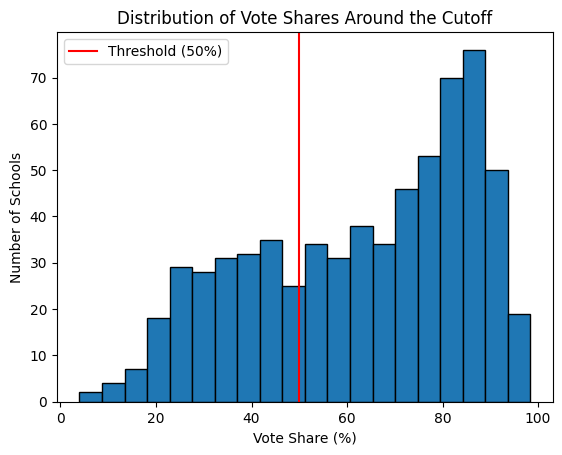

In [10]:
plt.hist(df['vote'], bins=20, edgecolor='black')
plt.axvline(x=50, color='red', label='Threshold (50%)')
plt.xlabel("Vote Share (%)")
plt.ylabel("Number of Schools")
plt.title("Distribution of Vote Shares Around the Cutoff")
plt.legend()
plt.show()

Q1 (g)
One of the main RDD assumptions that we have not yet addressed is that schools cannot manipulate their vote and determine which side of the discontinuity they fall on. We can test this by determining the density of schools around the cutoff. Looking at a histogram of votes, we see that the data isn't necessarily smooth around the discontinuity, which suggests there may be potential manipulation. In particular, the density just below the cutoff is significantly less than the density just after it, implying it is possible that some schools may have artificially increased their vote count slightly upwards to hit 50%. Thus, we find another one of our RDD assumptions is somewhat challenged here.

Q1 (h)
In RDD, we measure the effect of receiving treatment (GM status)–the implication is that we seek to measure the effect of a phenomenon that applies more to observations around the discontinuity, since those observations arbitrarily less than the cutoff grow increasingly similar to observations arbitrarily more than the cutoff, meaning the difference in treatment effect may be viewed as more causal. Clearly then, we are measuring a phenomenon that is local to the discontinuity, and we see how RDD estimates the LATE (local average treatment effect). 

We find that internal validity is challenged if schools can manipulate which side of the discontinuity they fall on, or if our instrument is weak and crossing 50% to win the vote does not strongly predict treatment. Since our findings are locally relevant (to schools aorund the cutoff), it has weak external validity; schools that were strongly in one direction or another are less relevant here. Thhe weakness in external validity is true for RD designs in general.

We have that vote is an instrument for receiving treatment (GM status). Specifically, we can let win (vote≥50%) be our instrument, to make clear the connection to RDD. We can then use predicted GM status to estimate effect on student outcomes. Using IV, since only compilers contribute to the variation in treatment caused by the instrument, we can estimate the LATE just as with RDD. 

In [12]:
#Imbens-Kalyanaraman optimal bandwidth
def ik_optimal_bandwidth(X, Y, cutoff=50):
    """Computes the optimal bandwidth using the Imbens-Kalyanaraman method."""
    
    #center running variable at the cutoff
    X_centered = X - cutoff
    
    #std dev of X
    sigma_x = np.std(X_centered, ddof=1)
    
    #var of residuals
    X_with_const = sm.add_constant(X_centered)
    model = sm.OLS(Y, X_with_const).fit()
    sigma_y = np.std(model.resid, ddof=1)
    
    n = len(X)
    
    #IK bandwidth
    h_opt = 1.84 * sigma_x * ((sigma_y ** 2 / (n * (X_centered ** 2).mean())) ** (1/5))
    
    return h_opt

In [13]:
df['vote_centered'] = df['vote'] - 50 
X = df['vote_centered']
Y = df['passrate2'] - df['passrate0'] 

#compute the optimal bandwidth
h_opt = ik_optimal_bandwidth(X, Y, cutoff=0)  #centered at 0

#only want observations within the bandwidth
df_rdd = df[np.abs(df['vote_centered']) <= h_opt].copy()

#treatment group (Win = 1 if vote >= 50, otherwise 0)
df_rdd['win'] = (df_rdd['vote_centered'] >= 0).astype(int)

#separate data
df_left = df_rdd[df_rdd['win'] == 0]  
df_right = df_rdd[df_rdd['win'] == 1] 

X_left = sm.add_constant(df_left[['vote_centered']])
X_right = sm.add_constant(df_right[['vote_centered']])

model_left = sm.OLS(df_left['passrate2'] - df_left['passrate0'], X_left).fit()
model_right = sm.OLS(df_right['passrate2'] - df_right['passrate0'], X_right).fit()

treatment_effect = model_right.params['const'] - model_left.params['const']

print("Optimal IK Bandwidth:", h_opt)
print("Treatment Effect at the Cutoff:", treatment_effect)
print("\nResults Below Cutoff:\n", model_left.summary())
print("\nResults Above Cutoff:\n", model_right.summary())

Optimal IK Bandwidth: 6.8114878689799285
Treatment Effect at the Cutoff: 4.82015867944882

Results Below Cutoff:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                  0.007535
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.931
Time:                        00:16:41   Log-Likelihood:                -145.08
No. Observations:                  42   AIC:                             294.2
Df Residuals:                      40   BIC:                             297.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------

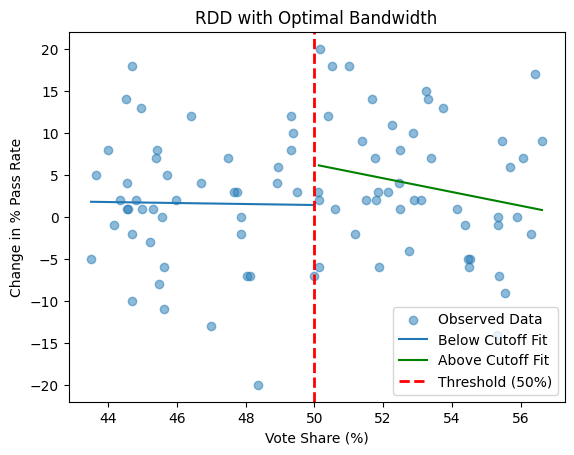

In [14]:
#scatter of raw data
plt.scatter(df_rdd['vote'], Y[df.index.isin(df_rdd.index)], alpha=0.5, label="Observed Data")

#prediction line
X_plot = np.linspace(df_rdd['vote'].min(), df_rdd['vote'].max(), 100)
X_plot_centered = X_plot - 50  

#predictions from local linear regression
Y_left_pred = model_left.predict(sm.add_constant(X_plot_centered[X_plot_centered < 0]))
Y_right_pred = model_right.predict(sm.add_constant(X_plot_centered[X_plot_centered >= 0]))

plt.plot(X_plot[X_plot_centered < 0], Y_left_pred, label="Below Cutoff Fit")
plt.plot(X_plot[X_plot_centered >= 0], Y_right_pred, color="green", label="Above Cutoff Fit")

plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label="Threshold (50%)")

plt.xlabel("Vote Share (%)")
plt.ylabel("Change in % Pass Rate")
plt.title("RDD with Optimal Bandwidth")
plt.legend()
plt.show()

Shows RDD with optimal bandwidth according to Imbens-Kalyanaraman. Now we vary the optimal bandwidth and see how the RDD changes

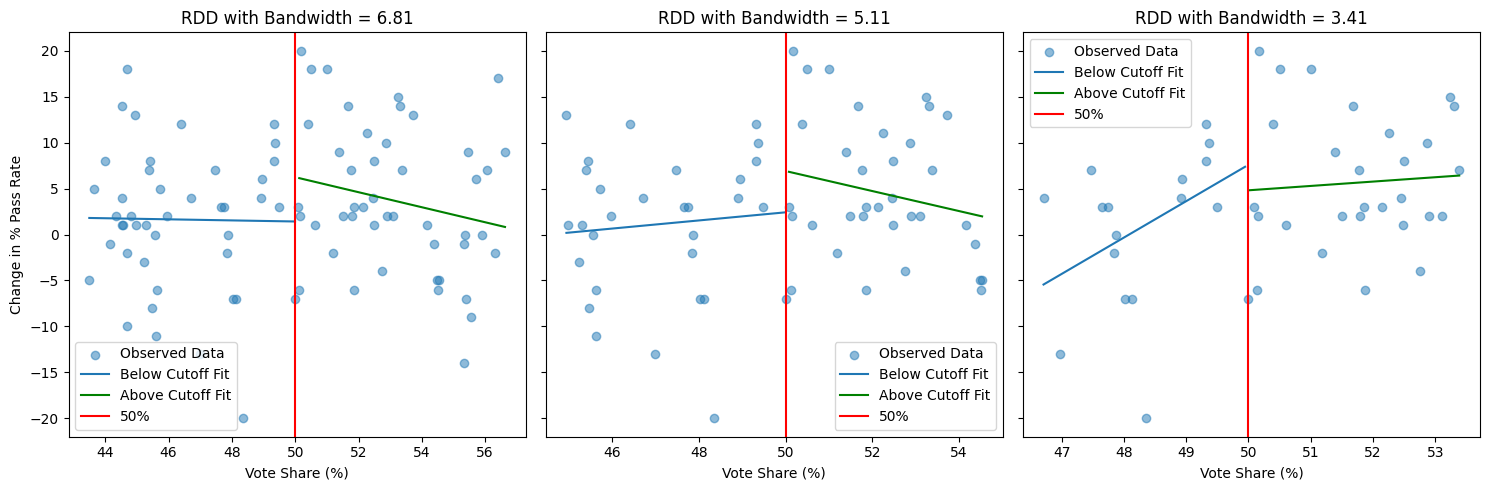

In [15]:
#tested IK optimal, 75%, 50%
bandwidths = [h_opt, 0.75 * h_opt, 0.5 * h_opt]

fig, axes = plt.subplots(1, len(bandwidths), figsize=(15, 5), sharey=True)

#create an RDD plot for each
for i, h in enumerate(bandwidths):
    df_rdd = df[np.abs(df['vote_centered']) <= h].copy()
    df_rdd['win'] = (df_rdd['vote_centered'] >= 0).astype(int)

    df_left = df_rdd[df_rdd['win'] == 0]
    df_right = df_rdd[df_rdd['win'] == 1]  

    X_left = sm.add_constant(df_left[['vote_centered']])
    X_right = sm.add_constant(df_right[['vote_centered']])

    model_left = sm.OLS(df_left['passrate2'] - df_left['passrate0'], X_left).fit()
    model_right = sm.OLS(df_right['passrate2'] - df_right['passrate0'], X_right).fit()

    ax = axes[i]
    ax.scatter(df_rdd['vote'], df_rdd['passrate2'] - df_rdd['passrate0'], alpha=0.5, label="Observed Data")

    X_plot = np.linspace(df_rdd['vote'].min(), df_rdd['vote'].max(), 100)
    X_plot_centered = X_plot - 50  

    Y_left_pred = model_left.predict(sm.add_constant(X_plot_centered[X_plot_centered < 0]))
    Y_right_pred = model_right.predict(sm.add_constant(X_plot_centered[X_plot_centered >= 0]))

    ax.plot(X_plot[X_plot_centered < 0], Y_left_pred, label="Below Cutoff Fit")
    ax.plot(X_plot[X_plot_centered >= 0], Y_right_pred, color="green", label="Above Cutoff Fit")


    ax.axvline(x=50, color='red', label="50%")

    ax.set_title(f"RDD with Bandwidth = {round(h, 2)}")
    ax.set_xlabel("Vote Share (%)")
    if i == 0:
        ax.set_ylabel("Change in % Pass Rate")

    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
#get the model summaries for plots above
for i, h in enumerate(bandwidths):
  
    df_rdd = df[np.abs(df['vote_centered']) <= h].copy()
    df_rdd['win'] = (df_rdd['vote_centered'] >= 0).astype(int)

    df_left = df_rdd[df_rdd['win'] == 0]  
    df_right = df_rdd[df_rdd['win'] == 1]  

    X_left = sm.add_constant(df_left[['vote_centered']])
    X_right = sm.add_constant(df_right[['vote_centered']])

    model_left = sm.OLS(df_left['passrate2'] - df_left['passrate0'], X_left).fit()
    model_right = sm.OLS(df_right['passrate2'] - df_right['passrate0'], X_right).fit()

    print(f"\nRDD Regression Results for Bandwidth = {round(h, 2)}\n")
    
    print("\nResults Below Cutoff:")
    display(model_left.summary())  

    print("\nResults Above Cutoff:")
    display(model_right.summary())  


RDD Regression Results for Bandwidth = 6.81


Results Below Cutoff:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                  0.007535
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.931
Time:                        00:20:48   Log-Likelihood:                -145.08
No. Observations:                  42   AIC:                             294.2
Df Residuals:                      40   BIC:                             297.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4189      2.850      0.498      0.621      -4.341       7.178
vote_centered    -0.0589      0.679     -0.087      0.931      -1.431       1.313
==============================================================================
Omnibus:                        2.319   Durbin-Watson:                   2.748
Prob(Omnibus):                  0.314   Jarque-Bera (JB):                1.445
Skew:                          -0.429   Prob(JB):                        0.485
Kurtosis:                       3.299   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Results Above Cutoff:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.005
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.164
Time:                        00:20:48   Log-Likelihood:                -162.95
No. Observations:                  47   AIC:                             329.9
Df Residuals:                      45   BIC:                             333.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.2391      2.120      2.944      0.005       1.970      10.508
vote_centered    -0.8177      0.577     -1.416      0.164      -1.981       0.345
==============================================================================
Omnibus:                        1.969   Durbin-Watson:                   2.522
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.320
Skew:                           0.134   Prob(JB):                        0.517
Kurtosis:                       2.224   Cond. No.                         7.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


RDD Regression Results for Bandwidth = 5.11


Results Below Cutoff:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.2018
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.657
Time:                        00:20:48   Log-Likelihood:                -100.70
No. Observations:                  29   AIC:                             205.4
Df Residuals:                      27   BIC:                             208.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.4165      3.285      0.736      0.468      -4.325       9.157
vote_centered     0.4414      0.983      0.449      0.657      -1.575       2.457
==============================================================================
Omnibus:                        4.318   Durbin-Watson:                   2.754
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                2.959
Skew:                          -0.761   Prob(JB):                        0.228
Kurtosis:                       3.366   Cond. No.                         7.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Results Above Cutoff:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.376
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.249
Time:                        00:20:48   Log-Likelihood:                -119.79
No. Observations:                  35   AIC:                             243.6
Df Residuals:                      33   BIC:                             246.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.9075      2.373      2.910      0.006       2.079      11.736
vote_centered    -1.0872      0.927     -1.173      0.249      -2.973       0.799
==============================================================================
Omnibus:                        2.407   Durbin-Watson:                   2.302
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                1.397
Skew:                           0.172   Prob(JB):                        0.497
Kurtosis:                       2.084   Cond. No.                         5.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


RDD Regression Results for Bandwidth = 3.41


Results Below Cutoff:


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.713
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.122
Time:                        00:20:48   Log-Likelihood:                -55.241
No. Observations:                  16   AIC:                             114.5
Df Residuals:                      14   BIC:                             116.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.5887      4.661      1.628      0.126      -2.409      17.586
vote_centered     3.9606      2.405      1.647      0.122      -1.197       9.118
==============================================================================
Omnibus:                        7.730   Durbin-Watson:                   2.675
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                4.512
Skew:                          -1.163   Prob(JB):                        0.105
Kurtosis:                       4.166   Cond. No.                         5.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Results Above Cutoff:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.1326
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.719
Time:                        00:20:48   Log-Likelihood:                -98.889
No. Observations:                  29   AIC:                             201.8
Df Residuals:                      27   BIC:                             204.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.8124      2.630      1.830      0.078      -0.583      10.208
vote_centered     0.4743      1.303      0.364      0.719      -2.199       3.147
==============================================================================
Omnibus:                        1.117   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                1.044
Skew:                           0.303   Prob(JB):                        0.593
Kurtosis:                       2.296   Cond. No.                         4.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Q1 (i) and (j)

We actually find when implementing these RDDs that most of the coefficients are insignificant. Few are even close to 0.05. Thus, we interpret our results with skepticism. We computed the 'optimal' bandwidth according to Imbens-Kalyanaraman, which is introduced in their 2011 paper 'Optimal Bandwidth Choice for the Regression Discontinuity Estimator' and seems to have become a standard method of doing so. We introduce variance by examining bandwidths determined by scalar multiples of the optimal bandwidth. We find that while the slopes differ somewhat, potentially such that decreasing the optimal bandwidth increases the disparity between the left and the right, the scatterplots do not seem to indicate obvious differences between the left and the right regressions.

Q2 (Van Der Klaauw, 2002)

(a) whether a student enrolls in college

(b) metric used to determine financial aid

(c) D is receiving financial aid; if a student meets a threshold in the metric for financial aid, they will receive it. This is a fuzzy design

(d) In a multiple regression model, we make strong assumptions such as heterogeneity and no omitted variable bias. In an RDD design, it is perhaps more believable to assume that students just above and below the cutoff are similar except for the treatment.

Q2 (DiNardo & Lee 2004)

(a) effect of unionization on business survival, employment, output, productivity, and wages

(b) union vote share in NLRB elections (% votes in favor of union)

(c) D is unionization status, determined such that if the union vote exceeds a threshold (50%), then D=1 and it is unionized. This is a sharp RDD since unionization is determined when the threshold is precisely when the threshold is reached

(d) In a multiple regression model, we make strong assumptions such as heterogeneity and no omitted variable bias. In an RDD design, it is perhaps more believable to assume that students just above and below the cutoff are similar except for the treatment.

Q2 (Chay & Greenstone, 2005)

(a) housing values

(b) concentration of TSPs/air quality in a county 

(c) D is the regulatory nonattainment status. IF the air quality is poor enough that it elevates TSPs beyond a threshold, the county is subject to stricter standards and D=1

(d) In a multiple regression model, we make strong assumptions such as heterogeneity and no omitted variable bias. In an RDD design, it is perhaps more believable to assume that students just above and below the cutoff are similar except for the treatment.

Q3 

(a) The main hypothesis tested in my paper, The Effect of Population Aging on Economic Growth, the Labor Force, and Productivity (Maestas et al, 2023), is whether an increasing fraction of the over 60 population has any effect of the labor market (productivity, wages, and growth, specifically)
(b) This hypothesis is clearly motivated by economic theory, as the mechanism by which labor force age impacts the market is debated
(c) We could set a fuzzy discontinuity when the fraction of the US economy ≥60 (or perhaps some other arbitrary but significant number, such as the age at which one can withdraw retirement savings) hits a certain number.